In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.utils import shuffle
import random

PDBs = pickle.load(open('PDBs_RDKit.pkl', 'rb'))
df = pd.read_csv('T_data.csv')

In [3]:
y = []
x_add = []
for i, pdb in enumerate(list(PDBs.keys())):
    y.append(df[df['Id'] == pdb]['exp'].to_numpy()[0])
    x_add.append(df[df['Id'] == pdb][['TS_comp', 'TS_host', 'TS_ligand']].to_numpy()[0])

In [4]:
PDB_keys = list(PDBs.keys())
PDB_keys_shuffled, y_shuffled, x_add_shuffled = shuffle(PDB_keys, y, x_add)
PDBs_shuffled = {k: PDBs[k] for k in PDB_keys_shuffled}

In [5]:
# to create a shuffled dataframe
x_add_shuffled = np.array(x_add_shuffled)
y_shuffled = np.array(y_shuffled)
df_shuffled = pd.DataFrame(data = {'Id': PDB_keys_shuffled, 'TS_comp': x_add_shuffled[:,0], 'TS_host': x_add_shuffled[:,1], 'TS_ligand': x_add_shuffled[:,2], 'exp': y_shuffled})
df_shuffled.to_csv('T_data_shuffled.csv')
pickle.dump(PDBs_shuffled, open('PDBs_RDKit_shuffled.pkl', 'wb'))

In [6]:
VM2_res =  - df['TS_comp'].to_numpy() + df['TS_host'].to_numpy() + df['TS_ligand'].to_numpy()

In [7]:
(df['exp'].to_numpy() - VM2_res).mean()

12.553096362253406

In [8]:
from scipy import stats
stats.kendalltau(df['exp'].to_numpy(), VM2_res)

KendalltauResult(correlation=0.058043213605073606, pvalue=0.38627572173895197)

In [9]:
K = 5
fold_size = len(PDBs) // K
PDBs_folds = [[PDBs[k] for k in PDB_keys_shuffled[i*fold_size:(i + 1)*fold_size]] for i in range(K)]
y_folds = [y_shuffled[i*fold_size:(i + 1)*fold_size] for i in range(K)]
x_add_folds = [x_add_shuffled[i*fold_size:(i + 1)*fold_size] for i in range(K)]

In [10]:
dbfile = open('PDBs_folds_%d.pkl' % K, 'wb')
pickle.dump(PDBs_folds, dbfile)                     
dbfile.close()
dbfile = open('y_folds_%d.pkl' % K, 'wb')
pickle.dump(y_folds, dbfile)                     
dbfile.close()
dbfile = open('x_add_folds_%d.pkl' % K, 'wb')
pickle.dump(x_add_folds, dbfile)                     
dbfile.close()

In [5]:
%cd ../../PGGCN/

/home/ali/GBNN/PGGCN


In [4]:
from models.dcFeaturizer import atom_features as get_atom_features


print('Data collected')

info = []
for pdb in list(PDBs.keys()):
    info.append(df[df['Id'] == pdb][['TS_comp', 'TS_host', 'TS_ligand']].to_numpy()[0])



def featurize(molecule, info):
    atom_features = []
    for atom in molecule.GetAtoms():
        new_feature = get_atom_features(atom).tolist()
        position = molecule.GetConformer().GetAtomPosition(atom.GetIdx())
        new_feature += [atom.GetMass(), atom.GetAtomicNum()]
        new_feature += [position.x, position.y, position.z]
        for neighbor in atom.GetNeighbors()[:2]:
            neighbor_idx = neighbor.GetIdx()
            new_feature += [neighbor_idx]
        for i in range(2 - len(atom.GetNeighbors())):
            new_feature += [-1]
        atom_features.append(np.concatenate([new_feature, info], 0))
    return np.array(atom_features)

X = []
y = []
for i, pdb in enumerate(list(PDBs.keys())):
    X.append(featurize(PDBs[pdb], info[i]))
    y.append(df[df['Id'] == pdb]['exp'].to_numpy()[0])

print('Input data prepared')
X, y = shuffle(X, y)
K = 4
fold_size = len(X) // K
X_folds = [X[i*fold_size:(i + 1)*fold_size] for i in range(K)]
y_folds = [y[i*fold_size:(i + 1)*fold_size] for i in range(K)]

2023-04-07 18:34:07.137300: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-07 18:34:07.175387: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-07 18:34:07.176233: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-07 18:34:07.808609: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Data collected
Input data prepared


In [18]:
dbfile = open('X_folds_4.pkl', 'wb')
pickle.dump(X_folds, dbfile)                     
dbfile.close()

In [19]:
dbfile = open('y_folds_4.pkl', 'wb')
pickle.dump(y_folds, dbfile)                     
dbfile.close()

In [20]:
x_f = pickle.load(open('X_folds_4.pkl', 'rb'))

In [21]:
x_f[0][0].shape

(140, 41)

In [2]:
hists = pickle.load(open('PGCN_K_fold_hists.pkl', 'rb'))
loss = pickle.load(open('PGCN_K_fold_test.pkl', 'rb'))

In [3]:
import matplotlib.pyplot as plt

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


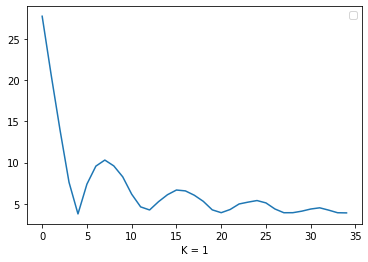

In [4]:
plt.plot(hists[0])
plt.xlabel('K = 1')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


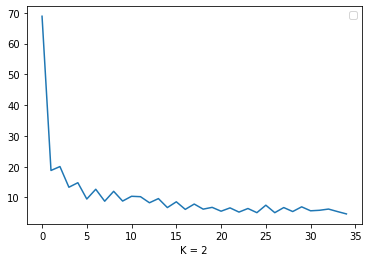

In [5]:
plt.plot(hists[1])
plt.xlabel('K = 2')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


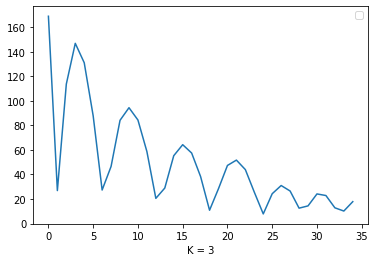

In [6]:
plt.plot(hists[2])
plt.xlabel('K = 3')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


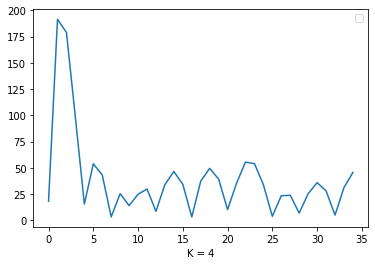

In [7]:
plt.plot(hists[3])
plt.xlabel('K = 4')
plt.legend()

In [1]:
import pickle

In [2]:
loss = pickle.load(open('PGCN_K_fold_test.pkl', 'rb'))

In [3]:
loss

[3.968169689178467, 4.4309234619140625, 3.518411636352539, 3.904867649078369]